In [1]:
import sys
# sys.path.insert(1, "/mnt/c/Users/billj/GitHub/SpikeCounter")
from spikecounter.analysis import traces

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
import scipy.signal as signal
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
# import seaborn as sbs
import os
from scipy.io import savemat
plt.style.use("/mnt/e/Cohen_Lab/Data/report.mplstyle")
# plt.style.use("/mnt/c/Users/billj/report.mplstyle")
# plt.style.use("../../report.mplstyle")

In [3]:
data_dir = "/mnt/e/Cohen_Lab/Data/20210510_gcamp_drugs/verapamil/"

In [4]:
fs=10.2
start_hpf = 20
expt_info = pd.read_csv(os.path.join(data_dir,"experiment_data.csv")).sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

### Plot masks

In [5]:
def intensity_to_dff(intensity, window=401):
    baseline = np.mean(intensity[intensity<np.percentile(intensity, 10)])
    dFF = (intensity - baseline)/baseline
    return dFF

def prefilter_intensity(raw_intensity):
    b, a = signal.butter(5, 0.5)
    intensity = signal.filtfilt(b, a, raw_intensity)
    mean_freq = 2.0
    b, a = signal.butter(5, [mean_freq-0.2,mean_freq+0.2], btype="bandstop", fs=10.2)
    intensity = signal.filtfilt(b, a, intensity)
    return intensity

def get_mean_signal_pd(data, rois, interval=(0,0), window = 401):
    start = interval[0]
    stop = interval[1]
    if stop == 0:
        stop = len(np.unique(data["t"]))
    dFF_mean = np.zeros(stop-start)
    dFFs = []
    for i, roi in enumerate(rois):
        intensity = prefilter_intensity(data.loc[roi]["mean_intensity"][start:stop])
        dFF = intensity_to_dff(intensity, window=window)
        dFF_mean = (dFF_mean*i + dFF)/(i+1)
        dFFs.append(dFF)
    return dFF_mean, dFFs

def get_mean_signal(data, rois, interval=(0,0), window = 401, background = None):
    start = interval[0]
    stop = interval[1]
    if stop == 0:
        stop = data.shape[1]
#     print(stop-start)

    dFF_mean = np.zeros(stop-start)
    dFFs = []
    for i, roi in enumerate(rois):
        intensity = prefilter_intensity(data[roi,start:stop])
        if background is not None:
            bi = prefilter_intensity(background[roi,start:stop])
            if np.mean(bi) < 0.8*np.mean(intensity):
                intensity = intensity - 0.8*bi
        dFF = intensity_to_dff(intensity, window=window)
        dFF_mean = (dFF_mean*i + dFF)/(i+1)
        dFFs.append(dFF)
    dFFs = np.array(dFFs)
    return dFF_mean, dFFs

def load_traces(expt_info, timepoints=None, per_trace_start=0, background_subtract=False, scale_lowest_mean=False, end_index=-1):
    if timepoints is None:
        timepoints = np.arange(0, expt_info.shape[0])

    window=401
    hours = []
    t = []
    data_blocks = []
    dFF_blocks = []
    baselines = []
    for idx in timepoints:
        exptname = expt_info["file_name"].loc[idx]
        offset = expt_info["offset"].loc[idx]
        data = pd.read_csv(os.path.join(data_dir, "%s_traces.csv" % exptname)).set_index("z").loc[0].set_index("region")
        data = data.reset_index().set_index("t")
        time_indices = np.sort(data.index.unique())
        time_indices = time_indices[:end_index]
        data = data.loc[time_indices]
        if background_subtract=="roi":
            background = pd.read_csv("background_traces/%s_traces.csv" % exptname).set_index("z").loc[0].set_index("region")
        elif isinstance(background_subtract, int):            
            background = data.loc[time_indices[-background_subtract:]]
            data = data.loc[time_indices[:-background_subtract]]
            background = background.reset_index().set_index("region")
#             print(data.shape)
#             print(background.shape)
        data = data.reset_index().set_index("region")
        t_timepoint = np.arange(len(np.unique(data["t"])))/fs +offset
        t_timepoint = t_timepoint[per_trace_start:]
        data_timepoint = np.zeros((len(data.index.unique("region")), len(t_timepoint)))
        background_timepoint = np.zeros((len(data.index.unique("region")), len(t_timepoint)))
        for i, roi in enumerate(data.index.unique("region")):
            data_timepoint[i,:] = data.loc[roi]["mean_intensity"][per_trace_start:]
#             if idx == 89:
#                 diff = np.percentile(data_timepoint[i,:198],10)\
#                 - np.percentile(data_timepoint[i,198:400],10)
#                 data_timepoint[i,:198] -= diff
#             elif idx == 88:
#                 diff = np.percentile(data_timepoint[i,:1090],10)\
#                 - np.percentile(data_timepoint[i,1090:1181],10)
#                 data_timepoint[i,1090:] += diff
            if background_subtract=="roi":
                background_timepoint[i,:] = background.loc[roi]["mean_intensity"][per_trace_start:]
            elif isinstance(background_subtract, int):
                data_timepoint[i,:] -= np.mean(background.loc[roi]["mean_intensity"])
        t.extend(list(t_timepoint))
        data_blocks.append(data_timepoint)
        baselines.append(np.mean(data_timepoint, axis=1))
        


    if scale_lowest_mean:
        baselines = np.array(baselines)
        print(baselines.shape)
        scalings = (baselines/np.min(baselines, axis=0)).T
        print(scalings.shape)
        for idx in range(baselines.shape[0]):
            data_blocks[idx] = data_blocks[idx]/scalings[:,idx][:,np.newaxis]
    
    for idx in range(len(data_blocks)):
        if background_subtract=="roi":
            dFF_mean, dFFs = get_mean_signal(data_blocks[idx], np.arange(data_blocks[idx].shape[0]), interval=(0,0), window=window, background=background_timepoint)
        else:
            dFF_mean, dFFs = get_mean_signal(data_blocks[idx], np.arange(data_blocks[idx].shape[0]), interval=(0,0), window=window, background=None)
        dFF_blocks.append(dFFs)

    t = np.array(t)
    t_interp = np.arange(np.min(t), np.max(t), step=1/fs)
    missing_data = np.zeros_like(t_interp, dtype=int)
    for t_idx in range(len(missing_data)):
        nearest_dist = np.min(np.abs(t-t_interp[t_idx]))
        if nearest_dist > 1/fs:
            missing_data[t_idx] = 1
    data_blocks = np.concatenate(data_blocks, axis=1)
    dFF_blocks = np.concatenate(dFF_blocks, axis=1)
    data_interp = np.zeros((data_blocks.shape[0], len(t_interp)))
    dFF_interp = np.zeros((dFF_blocks.shape[0], len(t_interp)))

    for roi in range(data_interp.shape[0]):
        f_trace = interpolate.interp1d(t, data_blocks[roi,:])
        data_interp[roi,:] = f_trace(t_interp)
        f_dff = interpolate.interp1d(t, dFF_blocks[roi,:])
        dFF_interp[roi,:] = f_dff(t_interp)
    return t_interp, data_interp, dFF_interp, missing_data

In [6]:
timepoints = np.concatenate([np.arange(1,40), np.arange(41,62), np.arange(63,67), np.arange(68,75)])
t, raw, dff, missing = load_traces(expt_info, timepoints=timepoints, per_trace_start=1, background_subtract=18, end_index=1198, scale_lowest_mean=False)
hours = t/3600 + start_hpf

In [7]:
dobj = traces.TimelapseArrayExperiment(data_dir,20, 10.2)

In [8]:
def custom_lp_filter(raw, norm_thresh=0.5):
    b, a = signal.butter(5, norm_thresh)
    intensity = signal.filtfilt(b, a, raw)
    mean_freq = 2.0
    b, a = signal.butter(5, [mean_freq-0.2, mean_freq+0.2], btype="bandstop", fs=10.2)
    intensity = signal.filtfilt(b, a, intensity)
    return intensity

In [9]:
timepoints = np.concatenate([np.arange(1,40), np.arange(41,62), np.arange(63,67), np.arange(68,75)])
dobj.load_traces(timepoints=timepoints, per_trace_start=1, background_subtract=18, end_index=1198, \
                 scale_lowest_mean=True, filter_function = lambda x: custom_lp_filter(x))

In [10]:
dobj.analyze_peaks()

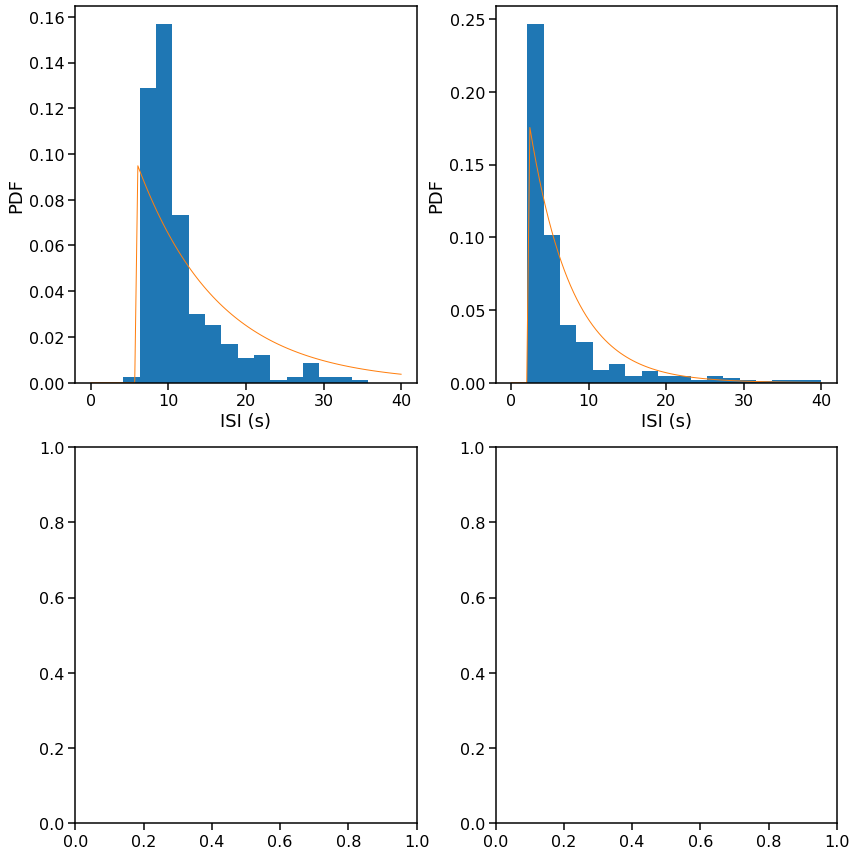

In [12]:
fig1, ax1 = dobj.plot_isi_histograms([1,2], [22,22])
plt.tight_layout()

[5, 6, 8, 9]


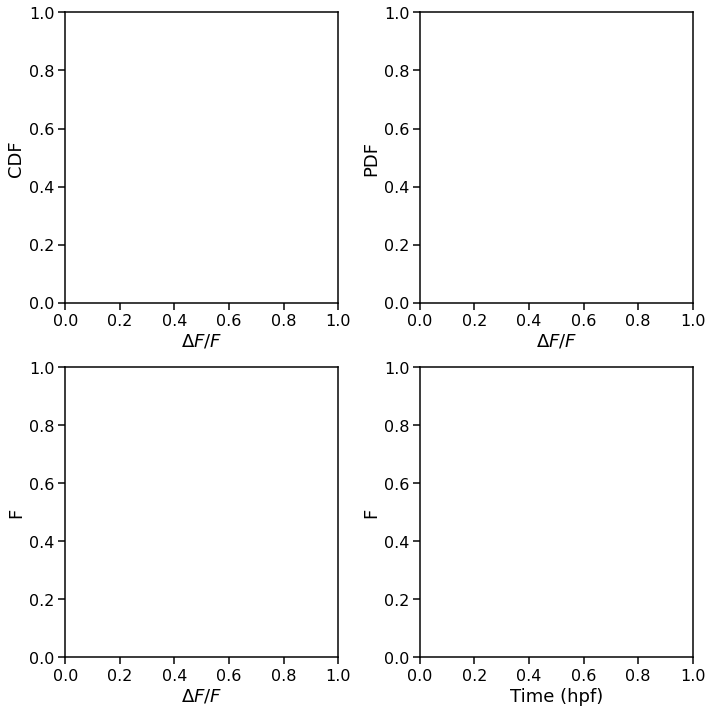

In [12]:
dobj.plot_peak_quality_metrics([5,6,8,9])
plt.tight_layout()

(<Figure size 864x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time (s)', ylabel='$\\Delta F/F$'>)

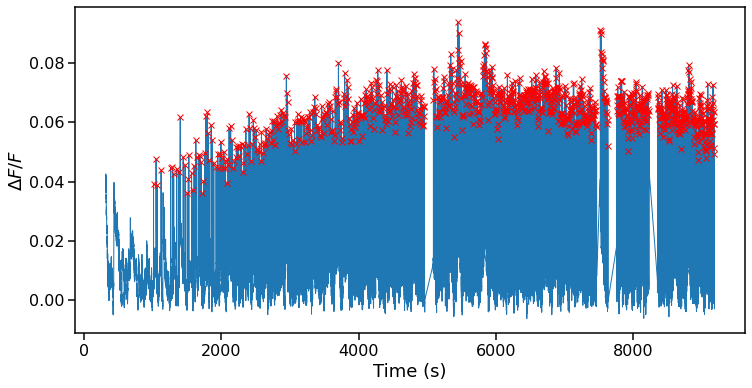

In [13]:
dobj.plot_spikes(9)

In [14]:
offsets = []
for i in timepoints:
    offsets.append(expt_info["offset"].loc[i]/3600 + start_hpf)

In [15]:
nice_embryos = [1,2,4,5,6,7,9,10]

Text(0.5, 0, 'HPF')

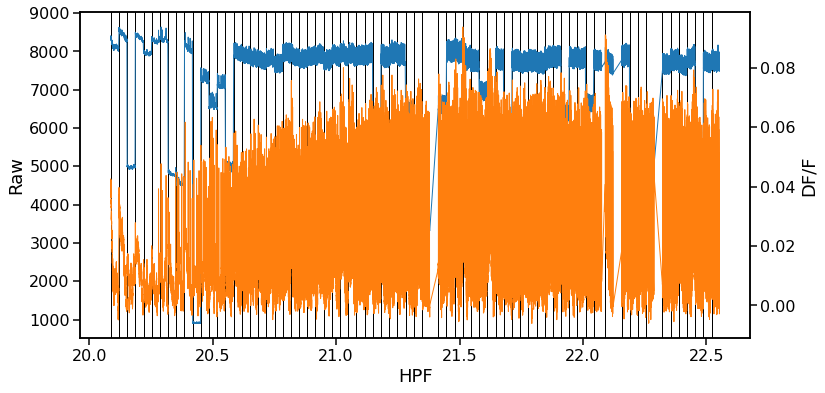

In [16]:
embryo = 10
roi = embryo -1
fig1, ax1 = plt.subplots(figsize=(12,6))
for o in offsets:
    ax1.axvline(o, color="black")
ax2 = ax1.twinx()
ax1.plot(hours, raw[roi,:])
start_time = 20.4
# ax1.set_xlim((start_time,start_time+0.3))
ax2.plot(hours, dff[roi,:], color="C1")
ax1.set_ylabel("Raw")
ax2.set_ylabel("DF/F")
ax1.set_xlabel("HPF")

### Check correlation between DF/F and F on spikes

Here embryos that are observed to undergo the sharp transition

(0.0972997702076783, 0.00010611025194003403)
(0.12212133371703429, 8.613147107017528e-06)
(0.08627172248613663, 1.396772104413344e-07)
(0.1019856600344541, 0.00010523942014955348)
(0.10575901934515566, 3.998358022700821e-08)
(0.08843636520949946, 1.2823948359763814e-05)
(0.08205750458991061, 6.868682164044042e-05)
(0.08214711133845401, 4.980982037530639e-06)
(0.18401802057611205, 2.5278863689443322e-30)
(0.15877486674777957, 1.2296429520350788e-15)
(0.05376069892302981, 0.012095870455679843)


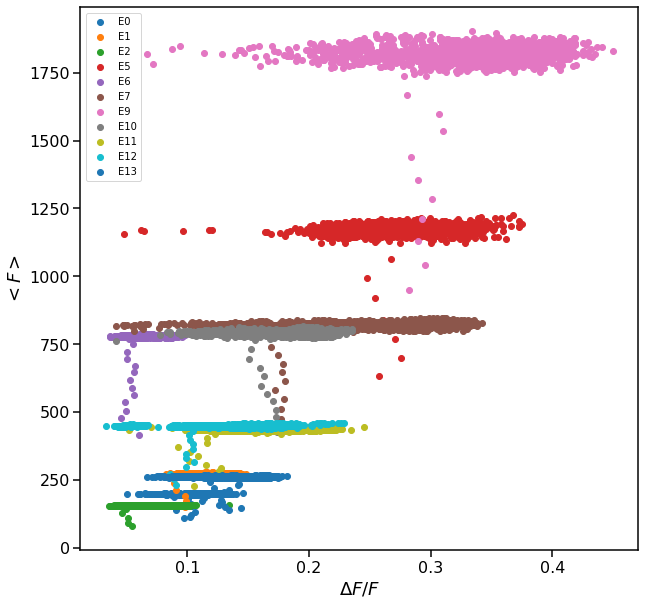

In [104]:
prominence = 0.04
fig1, ax1 = plt.subplots(figsize=(10,10))
for e in nice_embryos:
    roi = e-1
    peaks, properties = signal.find_peaks(dff[roi,:], prominence=prominence, wlen=400)
    peaks = peaks[dff[roi,peaks]>0]
    window = 400
    ma = np.convolve(raw[roi,:], np.ones(window)/window, 'same')
    ax1.scatter(dff[roi,peaks], ma[peaks], label="E%d" %(roi+1))
    print(stats.pearsonr(dff[roi,peaks],ma[peaks]))
ax1.set_xlabel(r"$\Delta F/F$")
ax1.set_ylabel(r"$<F>$")
ax1.legend()

(-0.11786756601014851, 0.003988183368389963)
-22.717942326494978
-52.72804296975229
(-0.14117031585405987, 0.0003593657747608446)
-24.499314229397637
-51.47843477523315
(-0.12054445319133927, 0.0008967705003584261)
-21.468688097494905
-67.96277647606233
(-0.12067089681051833, 0.002834362207327528)
-13.996229986337173
-11.772506219344786
(-0.13607708990885045, 0.000324302339251222)
-26.42556056576169
-24.046783592633126


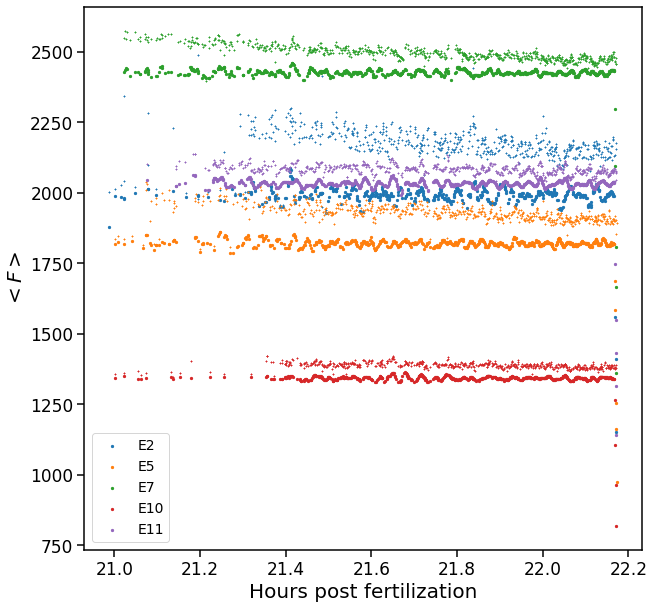

In [29]:
prominence = 0.015
fig1, ax1 = plt.subplots(figsize=(10,10))
for idx, roi in enumerate([1,4,6,9,10]):
    peaks, properties = signal.find_peaks(dff[roi,:], prominence=prominence, wlen=400)
    peaks = peaks[dff[roi,peaks]>0]
    window = 400
    ma = np.convolve(raw[roi,:], np.ones(window)/window, 'same')
    ax1.scatter(hours[peaks], ma[peaks], color="C%d" %idx, label="E%d" %(roi+1),s=5,linewidth=1)
    ax1.scatter(hours[peaks], raw[roi,peaks], color="C%d" %idx, marker="+", s=5, linewidth=1)
    print(stats.pearsonr(hours[peaks],ma[peaks]))
    print(stats.linregress(hours[peaks],ma[peaks]).slope)
    print(stats.linregress(hours[peaks],raw[roi,peaks]).slope)
ax1.set_xlabel(r"Hours post fertilization")
ax1.set_ylabel(r"$<F>$")
ax1.legend()

### Detect peaks

Note here: we can do two different kinds of analysis. 1) Look at spikes that exceed a set threshold that we define as a heartbeat , and 2) Look at the "spikiest" spikes in each trace.

In [23]:
def detect_peaks(e_data, prominence="auto"):
    if prominence == "auto":
        p = np.percentile(e_data, 95)/2
        peaks, properties = signal.find_peaks(e_data, prominence=p, height=0, wlen=400)
    else:
        peaks, properties = signal.find_peaks(e_data, prominence=prominence, height=0, wlen=400)
    return peaks, properties

In [25]:
embryo = 2
e_data = dff[embryo-1,:]
peaks,properties = detect_peaks(e_data)

In [30]:
np.mean(properties["prominences"])

0.0282880532647496

In [29]:
np.mean(dobj.peaks_data.loc[embryo-1]["prominence"])

0.0282880532647496

In [22]:
np.all(peaks==dpeaks)

True

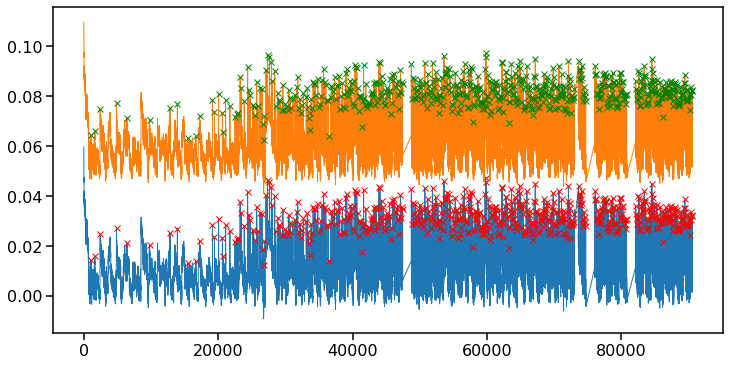

In [21]:
fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(e_data)
ax1.plot(peaks, e_data[peaks], "rx")
offset = 0.05
ax1.plot(dobj.dFF[embryo-1,:]+offset)
dpeaks = dobj.peaks_data.loc[embryo-1]["peak_idx"]
ax1.plot(dpeaks, dobj.dFF[embryo-1,dpeaks]+offset, "gx")
# ax1.set_xlim(0,1000)

### Check frequency change over developmental time for selected embryos

Try with sliding window method

In [20]:
def find_segment_edges(missing_data):
    missing_edges = missing_data[1:] - missing_data[:-1]
    rising_edge = np.argwhere(missing_edges==1).ravel()
    falling_edge = np.argwhere(missing_edges==-1).ravel()
    segment_edges = list(zip([0] + list(falling_edge[:len(rising_edge)-1]), list(rising_edge)))
    return segment_edges

def generate_peak_detection_stats(dff, rois, window, prominence, overlap=0.5, missing_data=None, sta_length = 50, sta_leadup=10):
    spike_stats_by_roi = []
    if missing_data is None:
        segment_edges = [(0, dff.shape[1])]
    else:
        segment_edges = find_segment_edges(missing_data)
    
    sta_embryos = {}
    ststd_embryos = {}
    for roi in rois:
        e_data = dff[roi,:]
        if prominence == "auto":
            p = np.percentile(e_data, 95)/2
            peaks, properties = signal.find_peaks(e_data, prominence=p, height=0, wlen=400)
        else:
            peaks, properties = signal.find_peaks(e_data, prominence=prominence, height=0, wlen=400)

#         threshold = np.percentile(e_data[peaks], 10)
        threshold = 0
        peak_prominence = properties["prominences"][e_data[peaks]>threshold]
        peaks = peaks[e_data[peaks]>threshold]
        width_results = signal.peak_widths(e_data, peaks, rel_height=0.5)
    #     print(width_results)
        window_indices = np.arange(0, len(e_data)-window, step=int(window - overlap*window))
        sta = np.zeros((len(window_indices), sta_length+sta_leadup))
        ststd = np.zeros((len(window_indices), sta_length+sta_leadup))
#         print(sta.shape)
        for wi_idx, i in enumerate(window_indices):
            peak_indices = (peaks>=i)*(peaks<(i+window))
            window_peaks = peaks[peak_indices]
#             print(wi_idx, len(window_peaks))
            if sta_length > 0:
                spike_traces = np.zeros((len(window_peaks), sta_length+sta_leadup))
    #             print(spike_traces.shape)
                for wp_idx, wp in enumerate(window_peaks):
                    spike_trace = np.concatenate([np.zeros(max(sta_leadup - wp, 0)),
                                                           e_data[max(0, wp-sta_leadup):min(len(e_data),wp+sta_length)],
                                                 np.zeros(max(0, wp+sta_length - len(e_data)))])
                    spike_traces[wp_idx,:] = spike_trace/np.nanmax(spike_trace)
                sta[wi_idx, :] = np.nanmean(spike_traces, axis=0)
                ststd[wi_idx,:]= np.nanstd(spike_traces, axis=0)
                if len(window_peaks)> 0:
                    relmin, _ = signal.find_peaks(1-sta[wi_idx,sta_leadup:], height=0.5)
                    if len(relmin) > 0:
                        relmin = relmin[0]
                    else:
                        relmin = spike_traces.shape[1]-sta_leadup
    #                 print(relmin)
                    ts = np.tile(np.arange(relmin)*1/fs,spike_traces.shape[0])
                    ys = spike_traces[:,sta_leadup:relmin+sta_leadup].ravel()
                    popt, pcov = optimize.curve_fit(lambda x, alpha, c: np.exp(-alpha*x) + c, ts, ys, p0=[0.6, 0.2])

                    alpha = popt[0]
                    c = popt[1]
                    alpha_err = np.sqrt(pcov[0,0])
                    c_err = np.sqrt(pcov[1,1])
                else:
                    alpha = np.nan
                    c = np.nan
                    alpha_err = np.nan
                    c_err = np.nan
            else:
                alpha = np.nan
                c = np.nan
                alpha_err = np.nan
                c_err = np.nan
            mean_prom = np.mean(peak_prominence[peak_indices])
            
            mean_width = np.mean(width_results[0][peak_indices])/fs
            isi = []
            for edge_pair in segment_edges:
                segment_peaks = window_peaks[(window_peaks >= edge_pair[0])*(window_peaks <= edge_pair[1])]
                if len(segment_peaks) > 1:
    #                 hpf = t[i]/3600 + start_hpf
                    isi.extend(list((segment_peaks[1:] - segment_peaks[:-1])/fs))
            mean_isi = np.mean(isi)
            n_intervals = len(isi)
            if n_intervals > 5:
                std_isi = np.std(isi)
                std_width = np.std(width_results[0][peak_indices]/fs)
            else:
                std_isi = np.nan
                std_width = np.nan
            mean_freq = len(window_peaks)/((window - np.sum(missing[i:i+window]))/fs)
            spike_stats_by_roi.append((roi+1, t[i], mean_freq, mean_isi, std_isi, mean_prom, mean_width, std_width, n_intervals, alpha, alpha_err, c, c_err))
        sta_embryos[roi+1] = sta
        ststd_embryos[roi+1] = ststd
    spike_stats_by_roi = pd.DataFrame(spike_stats_by_roi, columns=["embryo", "offset", "mean_freq", "mean_isi", "std_isi", "mean_prom", "mean_width", "std_width", "n_intervals", "alpha", "alpha_err", "c", "c_err"])
    spike_stats_by_roi["hpf"] = spike_stats_by_roi["offset"]/3600 + start_hpf
    return spike_stats_by_roi, sta_embryos, ststd_embryos


In [21]:
spike_stats_by_roi = []
rois = np.arange(dff.shape[0])
window = 1200
overlap = 0.9
prominence = "auto"
spike_stats_by_roi, sta_embryos, ststd_embryos = generate_peak_detection_stats(dff, rois, window, prominence, overlap=overlap, missing_data=missing)
spike_stats_by_roi = spike_stats_by_roi.reset_index().set_index("embryo")

/home/billj/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/home/billj/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/billj/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/billj/.local/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/billj/.local/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars


In [23]:
droi

,index,mean_isi,std_isi,mean_prom,std_prom,mean_width,std_width,n_peaks,offset,mean_freq
roi,,,,,,,,,,
0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,312.098039,0.000000
0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,323.862745,0.000000
0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,335.627451,0.000000
0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,347.392157,0.000000
0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,359.156863,0.000000
...,...,...,...,...,...,...,...,...,...,...
10.0,8190,8.011204,0.387629,0.022681,0.003621,1.255731,0.292471,14.0,9017.980392,0.123529
10.0,8191,8.081232,0.368164,0.022431,0.003824,1.260733,0.286721,14.0,9029.745098,0.123529
10.0,8192,8.182504,0.437796,0.022695,0.003766,1.270947,0.293684,13.0,9041.509804,0.114706


In [22]:
droi, dsta, dststd = dobj.get_windowed_peak_stats(1200, overlap=0.9, sta_before=0, sta_after=0, isi_stat_min_peaks=8)

/mnt/e/Cohen_Lab/Code/SpikeCounter/spikecounter/analysis/traces.py:389: RuntimeWarning: invalid value encountered in double_scalars
  roi_spike_stats["mean_freq"] = roi_spike_stats["n_peaks"]/(window - np.sum(self.missing_data[wi:wi+window]))*self.f_s


KeyError: "None of ['roi'] are in the columns"

In [24]:
dobj.peaks_data

,peak_idx,prominence,fwhm,isi,t
roi,,,,,
0,31822,0.139666,1.840318,119.607843,3431.901961
0,33042,0.138837,1.632137,37.254902,3551.509804
0,33422,0.142923,1.693123,48.137255,3588.764706
0,33913,0.144908,1.791467,26.176471,3636.901961
0,34180,0.129825,1.431723,42.450980,3663.078431
...,...,...,...,...,...
10,90163,0.019804,1.090573,9.117647,9151.607843
10,90256,0.023542,1.337983,6.960784,9160.725490
10,90327,0.019766,1.067929,8.529412,9167.686275


2.0399999999999996


/home/billj/miniconda3/lib/python3.9/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 255, using nperseg = 255
  warnings.warn('nperseg = {0:d} is greater than input length '


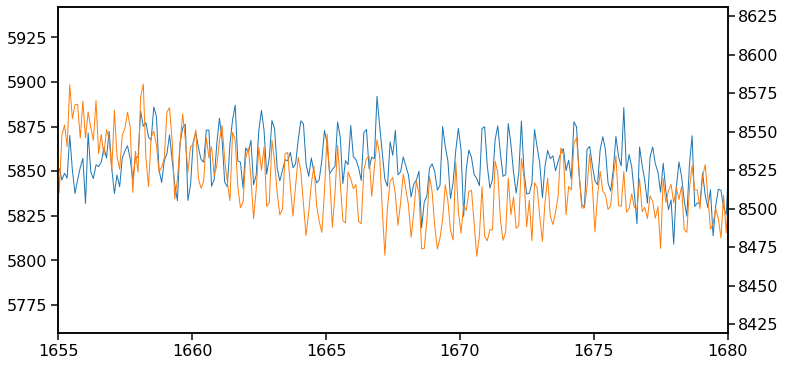

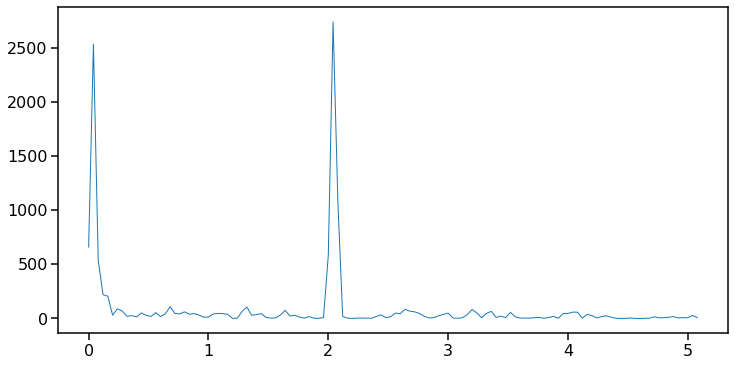

In [18]:
fig1, ax1 = plt.subplots(figsize=(12,6))
e1 = 3
e2 = 10
ax2 = ax1.twinx()
tmin = 1655
tmax = 1680
tidx_min = np.argwhere(t>tmin)[0][0]
tidx_max = np.argwhere(t>tmax)[0][0]
ax1.plot(t, raw[e1,:])
ax1.set_xlim((tmin, tmax))
ax1.set_ylim(min(raw[e1,tidx_min:tidx_max])-50, max(raw[e1,tidx_min:tidx_max]+50))

ax2.plot(t,raw[e2,:], color="C1")
ax2.set_ylim(min(raw[e2,tidx_min:tidx_max])-50, max(raw[e2,tidx_min:tidx_max]+50))
fig2, ax3 = plt.subplots(figsize=(12, 6))
f, pxx = signal.welch(raw[e2,tidx_min:tidx_max]-np.mean(raw[e2,tidx_min:tidx_max]), fs=fs)
ax3.plot(f,pxx)
print(f[np.argmax(pxx)])

In [67]:
q = np.divide(dff,np.max(dff, axis=1)[:,np.newaxis])
print(q.shape)

(11, 90581)


(0.08138647687079376, 0.22881408084393298)

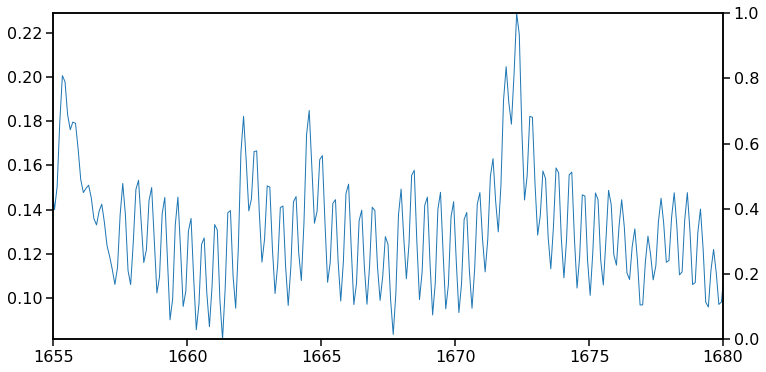

In [68]:
fig1, ax1 = plt.subplots(figsize=(12,6))
e1 = 3
e2 = 8
ax2 = ax1.twinx()
tmin = 1655
tmax = 1680
dff_mean = np.mean(np.divide(dff,np.max(dff, axis=1)[:,np.newaxis]), axis=0)
tidx_min = np.argwhere(t>tmin)[0][0]
tidx_max = np.argwhere(t>tmax)[0][0]
ax1.plot(t, dff_mean)
ax1.set_xlim((tmin, tmax))
ax1.set_ylim(min(dff_mean[tidx_min:tidx_max]), max(dff_mean[tidx_min:tidx_max]))


(0.09999536269276152, 0.20668178935339013)

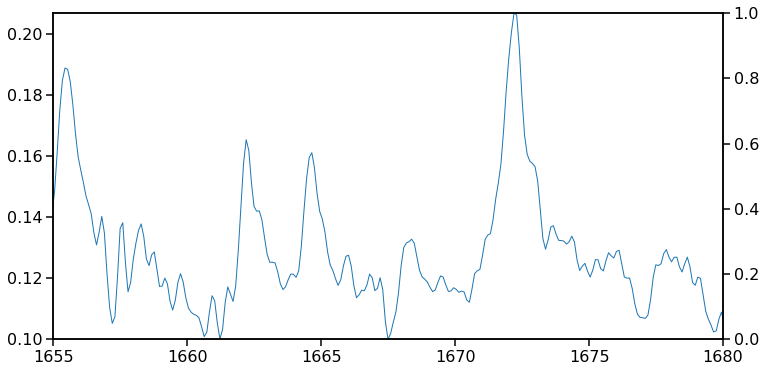

In [101]:
fig1, ax1 = plt.subplots(figsize=(12,6))
e1 = 3
e2 = 8
ax2 = ax1.twinx()
tmin = 1655
tmax = 1680
dff_mean = np.mean(np.divide(dff,np.max(dff, axis=1)[:,np.newaxis]), axis=0)
tidx_min = np.argwhere(t>tmin)[0][0]
tidx_max = np.argwhere(t>tmax)[0][0]
ax1.plot(t, dff_mean)
ax1.set_xlim((tmin, tmax))
ax1.set_ylim(min(dff_mean[tidx_min:tidx_max]), max(dff_mean[tidx_min:tidx_max]))


In [122]:
filename = "verapamil"
spike_stats_by_roi.to_csv("../%s.csv" % filename)
import pickle
with open("../%s_sta.pickle" % filename, 'wb') as f:
    pickle.dump(sta_embryos, f)
with open("../%s_ststd.pickle" % filename, 'wb') as f:
    pickle.dump(ststd_embryos, f)

Text(0, 0.5, 'Mean spike frequency (Hz)')

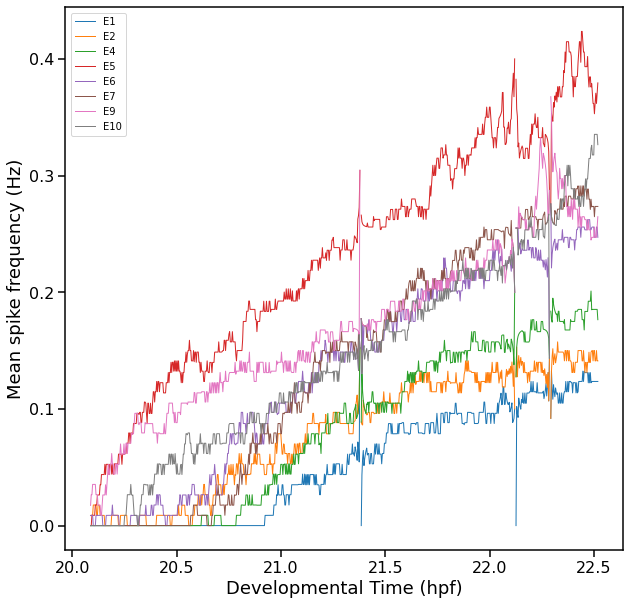

In [21]:
spike_stats_by_roi = spike_stats_by_roi.reset_index().set_index("embryo")
fig1, ax1 = plt.subplots(figsize=(10,10))
exclude_embryos = []
for embryo in nice_embryos:
    if embryo not in exclude_embryos:
        e_data = spike_stats_by_roi.loc[embryo]
        ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (embryo))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

Text(0, 0.5, 'Mean spike frequency (Hz)')

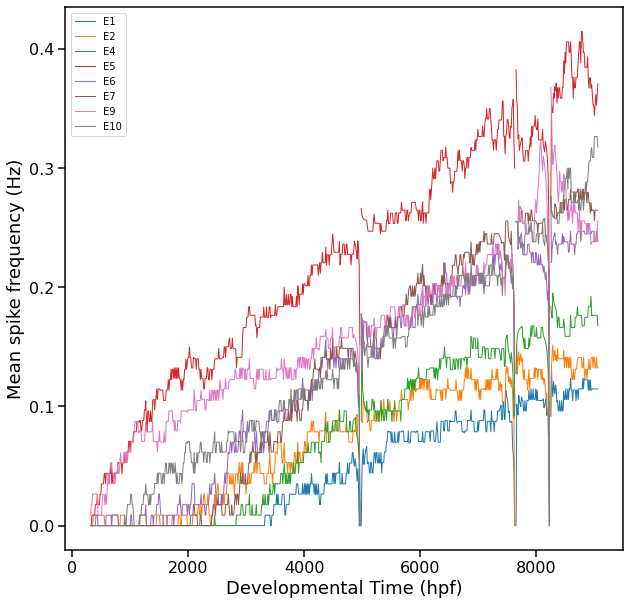

In [22]:
fig1, ax1 = plt.subplots(figsize=(10,10))
exclude_embryos = []
for embryo in nice_embryos:
    if embryo not in exclude_embryos:
        e_data = droi.loc[embryo-1]
        ax1.plot(e_data["offset"], e_data["mean_freq"], label= "E%d" % (embryo))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

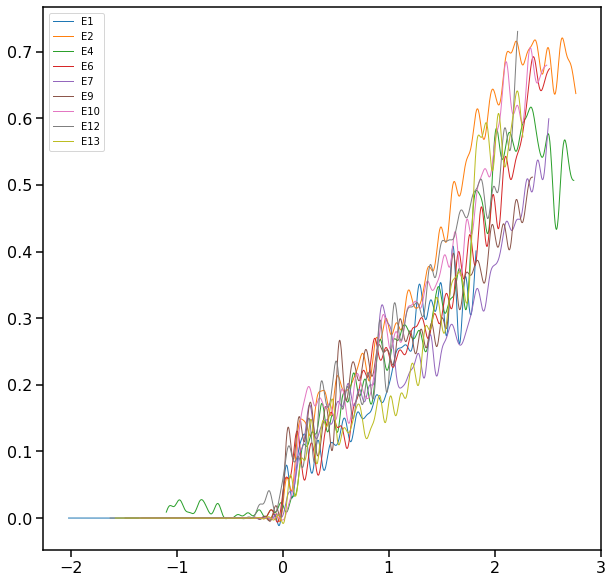

In [20]:
b, a = signal.butter(11, 0.07)
fig1, ax1 = plt.subplots(figsize=(10,10))
exclude_embryos = [5, 11, 14,3,8]
all_offsets = [0, 0, 0, 70, 50,0,0,100,0]
# all_offsets = [0, 0, 0, 0, 0,0,0]

curr_row = 0
for embryo in spike_stats_by_roi.index.unique():
    if embryo not in exclude_embryos:
        e_data = spike_stats_by_roi.loc[embryo]
        mean_freq = np.array(e_data["mean_freq"])
        smoothed_mean_freq = signal.filtfilt(b, a, e_data["mean_freq"])

        hpf = np.array(e_data["hpf"])
        first_idx = np.argwhere(mean_freq > 0.04)[0][0]
        last_idx = np.argwhere(mean_freq > 0.08)[0][0]
        res = stats.linregress(hpf[first_idx:last_idx], mean_freq[first_idx:last_idx])
        x_intercept = -res.intercept/res.slope
        offset = np.argmin(np.abs(hpf-x_intercept))
        all_offsets[curr_row] += offset
        ax1.plot(e_data["hpf"]-hpf[all_offsets[curr_row]], smoothed_mean_freq, label= "E%d" % (embryo))
        curr_row +=1
ax1.legend()

/home/billj/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/billj/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


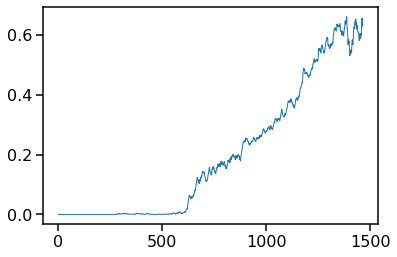

In [21]:
hpf = np.array(spike_stats_by_roi.loc[1]["hpf"])
hpf_offsets = hpf[all_offsets]
aligned_frequencies = np.nan*np.ones((len(spike_stats_by_roi.index.unique())-len(exclude_embryos), \
                                      hpf.shape[0]+max(all_offsets)))
aligned_alphas = np.nan*np.ones((len(spike_stats_by_roi.index.unique())-len(exclude_embryos), \
                                      hpf.shape[0]+max(all_offsets)))
unaligned_frequencies = np.zeros((len(spike_stats_by_roi.index.unique())-len(exclude_embryos), hpf.shape[0]))
alphas = np.zeros((len(spike_stats_by_roi.index.unique())-len(exclude_embryos), hpf.shape[0]))
curr_row = 0
for embryo in spike_stats_by_roi.index.unique():
    if embryo not in exclude_embryos:
        e_data = spike_stats_by_roi.loc[embryo]
        mean_freq = np.array(e_data["mean_freq"])
#         mean_freq = signal.filtfilt(b,a, mean_freq)
        start_idx = aligned_frequencies.shape[1] - e_data["hpf"].shape[0] - all_offsets[curr_row]
        aligned_frequencies[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            mean_freq
        aligned_alphas[curr_row, start_idx:start_idx+e_data["hpf"].shape[0]] = \
            np.array(e_data["alpha"])
        unaligned_frequencies[curr_row, :] = e_data["mean_freq"]
        alphas[curr_row, :] = e_data["alpha"]
        curr_row +=1
plt.plot(np.nanmean(aligned_frequencies, axis=0))
savemat("../expt_mean_freq.mat", {"idx_offsets": all_offsets, "all_freqs":unaligned_frequencies, "all_freqs_aligned":aligned_frequencies, "alphas":alphas, "alphas_aligned": aligned_alphas,"mean_freq": np.nanmean(aligned_frequencies, axis=0), "hpf":hpf})

In [33]:
spike_stats_by_roi.loc[2]

embryo           1.000000
offset         383.627451
mean_freq        0.000000
mean_isi              NaN
std_isi               NaN
mean_prom             NaN
mean_width            NaN
std_width             NaN
n_intervals      0.000000
hpf             19.106563
Name: 2, dtype: float64

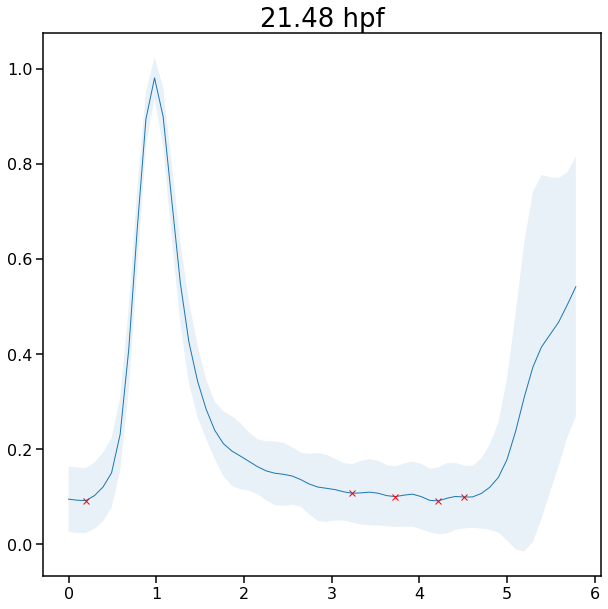

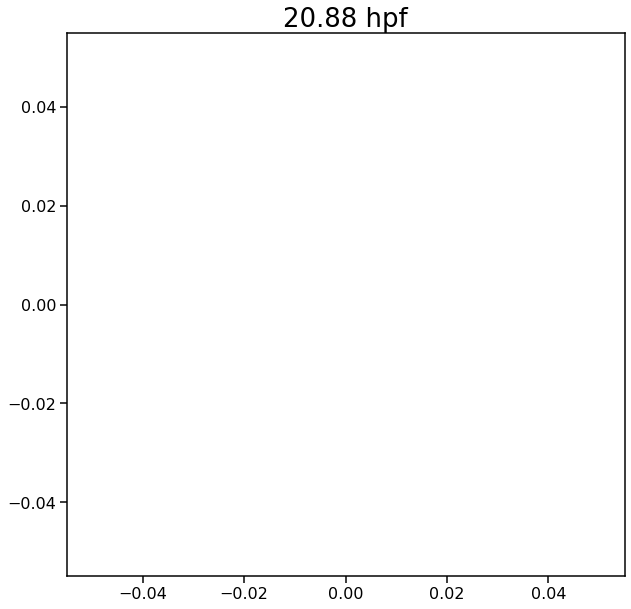

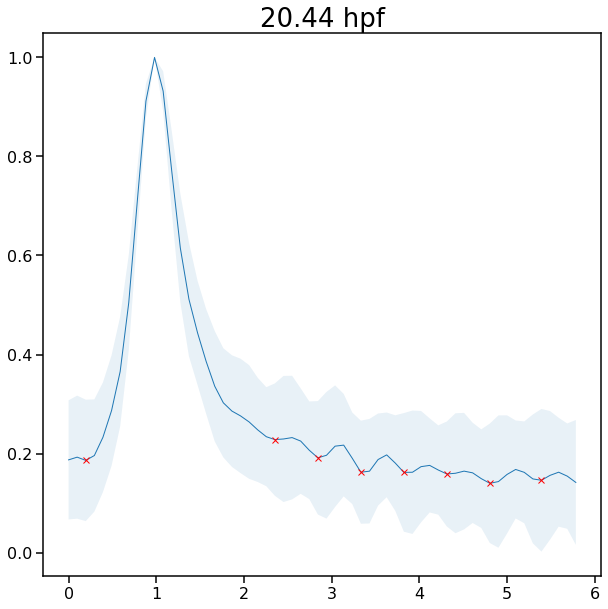

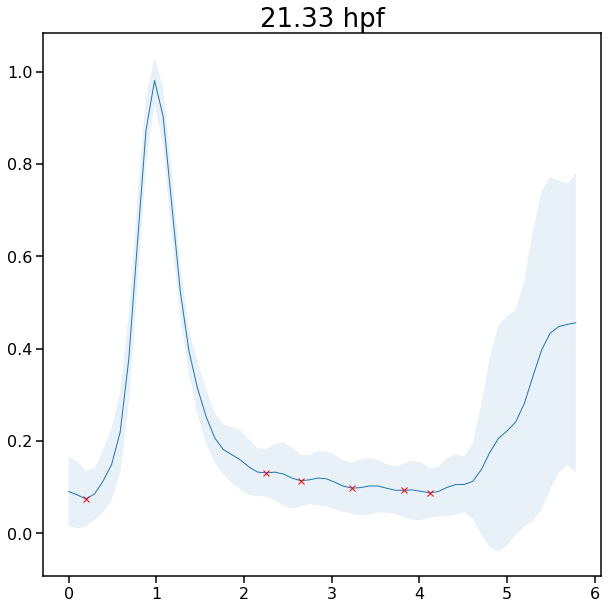

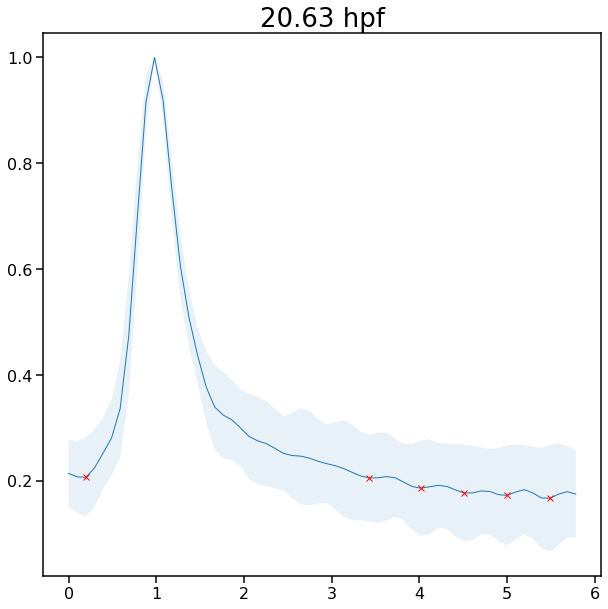

In [94]:
embryo = 6
sta = sta_embryos[embryo]
ststd = ststd_embryos[embryo]
hpf = np.array(spike_stats_by_roi.loc[embryo]["hpf"])
n_random_indices = 5
random_indices = np.random.choice(np.arange(np.argwhere(hpf>20.25)[0][0], len(hpf)), size=n_random_indices, replace=False)
ticks = np.arange(sta.shape[1])*1/fs
for i in random_indices:
    figure1, ax1 = plt.subplots(figsize=(10,10))
    ax1.plot(ticks,sta[i,:])
    relmin, _ = signal.find_peaks(1-sta[i,:], height=0.5)
    ax1.plot(ticks[relmin], sta[i,relmin], "rx")
    ax1.fill_between(ticks,sta[i,:] - ststd[i,:], sta[i,:] + ststd[i,:], alpha=0.1)
    ax1.set_title("%.2f hpf" % hpf[i])

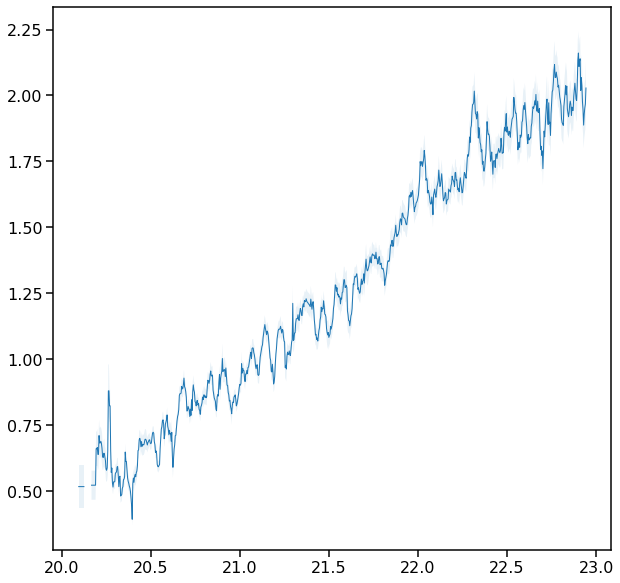

In [81]:
figure1, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(spike_stats_by_roi.loc[embryo]["hpf"],spike_stats_by_roi.loc[embryo]["alpha"])
ax1.fill_between(spike_stats_by_roi.loc[embryo]["hpf"], \
                 spike_stats_by_roi.loc[embryo]["alpha"]-spike_stats_by_roi.loc[embryo]["alpha_err"],
                 spike_stats_by_roi.loc[embryo]["alpha"]+spike_stats_by_roi.loc[embryo]["alpha_err"], alpha=0.1)

In [108]:
spike_stats_by_roi = []
rois = np.arange(dff.shape[0])
window = 6120
overlap = 0.9
prominence = "auto"
spike_stats_by_roi, _, _ = generate_peak_detection_stats(dff, rois, window, prominence, overlap=overlap, missing_data=missing,sta_length=0)
spike_stats_by_roi = spike_stats_by_roi.reset_index().set_index("embryo")

/home/billjia/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
hpf_new = np.array(spike_stats_by_roi.loc[1]["hpf"])
edata = spike_stats_by_roi.loc[1]
new_offsets = [np.argwhere(hpf_new>=hpf_offsets[i])[0][0] for i in range(len(hpf_offsets))]
aligned_cov = np.nan*np.ones((len(spike_stats_by_roi.index.unique())-len(exclude_embryos), \
                                      e_data["hpf"].shape[0]+max(new_offsets)))
unaligned_cov = np.zeros((len(spike_stats_by_roi.index.unique())-len(exclude_embryos), e_data["hpf"].shape[0]))
curr_row = 0
for embryo in spike_stats_by_roi.index.unique():
    if embryo not in exclude_embryos:
        e_data = spike_stats_by_roi.loc[embryo]
        cov = np.array(e_data["std_isi"]/e_data["mean_isi"])
        start_idx = aligned_cov.shape[1] - e_data["hpf"].shape[0] - new_offsets[curr_row]
        print(cov.shape)
        aligned_cov[curr_row, start_idx:start_idx + e_data["hpf"].shape[0]] = \
            cov
        unaligned_cov[curr_row,:] = cov
        curr_row +=1

(223,)
(223,)
(223,)
(223,)
(223,)
(223,)
(223,)
(223,)
(223,)


In [17]:
savemat("../expt_cov.mat", {"unaligned_cov": unaligned_cov, "aligned_cov":aligned_cov, "hpf_cov": hpf_new, "mean_cov": np.nanmean(aligned_cov, axis=0)})

/home/billj/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


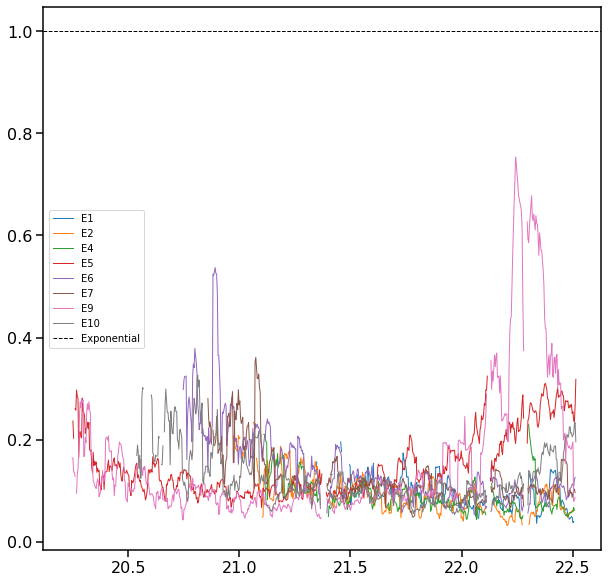

In [19]:
fig1, ax1 = plt.subplots(figsize=(10,10))
# rois = [1,4,6,9,10]
# embryos = [roi+1 for roi in rois]
# embryos = [2,3,4,6,8,9,10,12]
embryos = nice_embryos
lines = []
for embryo in embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["std_isi"]/e_data["mean_isi"], label= "E%d" % (embryo))
    lines.extend(l)
l = ax1.axhline(1.0, color="black", label="Exponential", ls='--')
lines.append(l)
ax1.legend(handles=lines)
# ax1.set_xlim(20, 22)

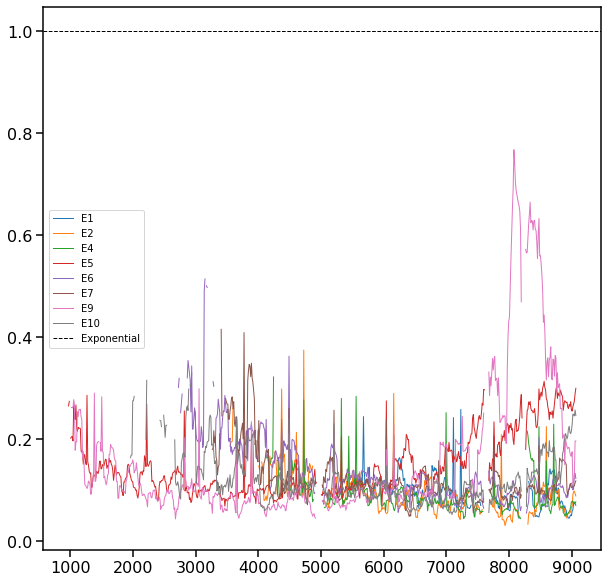

In [16]:
fig1, ax1 = plt.subplots(figsize=(10,10))
# rois = [1,4,6,9,10]
# embryos = [roi+1 for roi in rois]
# embryos = [2,3,4,6,8,9,10,12]
embryos = nice_embryos
lines = []
for embryo in embryos:
    e_data = droi.loc[embryo-1]
    l = ax1.plot(e_data["offset"], e_data["std_isi"]/e_data["mean_isi"], label= "E%d" % (embryo))
    lines.extend(l)
l = ax1.axhline(1.0, color="black", label="Exponential", ls='--')
lines.append(l)
ax1.legend(handles=lines)
# ax1.set_xlim(20, 22)

In [109]:
filename = "verapamil"
spike_stats_by_roi.to_csv("../%s_cv.csv" % filename)

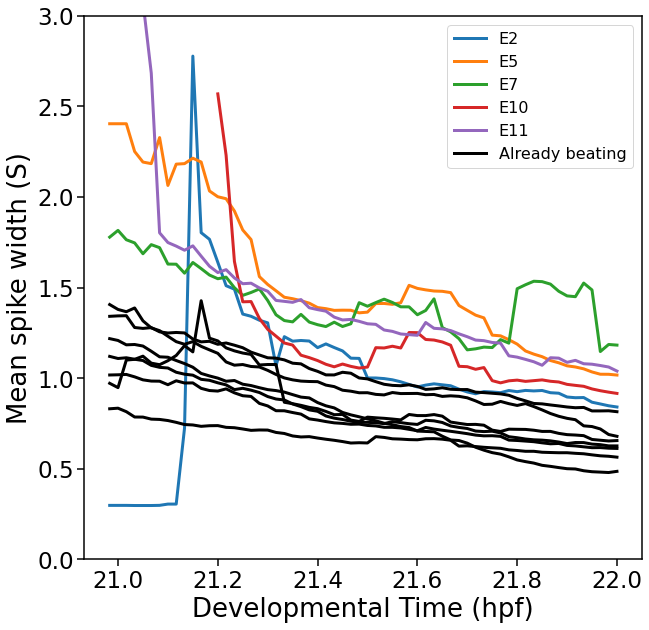

In [199]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["mean_width"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["mean_width"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"Mean spike width (S)")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
ax1.set_ylim(0,3)
lines.append(l)
ax1.legend(handles=lines)

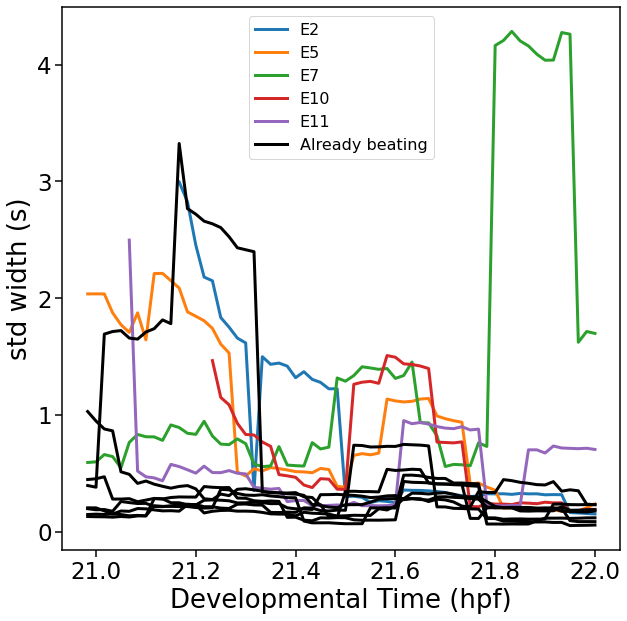

In [202]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:     for i in np.arange(0, len(e_data), step=int(window - overlap*window)):
            if len(e_data) - i < window:
                break
            peak_indices = (peaks>=i)*(peaks<(i+window))
            window_peaks = peaks[peak_indices]
            widths = (peak_prominence[peak_indices])
            
            mean_width = np.mean(width_results[0][peak_indices])/fs
            isi = []
            for edge_pair in segment_edges:
                segment_peaks = window_peaks[(window_peaks >= edge_pair[0])*(window_peaks <= edge_pair[1])]
                if len(segment_peaks) > 1:
    #                 hpf = t[i]/3600 + start_hpf
                    isi.extend(list((segment_peaks[1:] - segment_peaks[:-1])/fs))
            mean_isi = np.mean(isi)
            n_intervals = len(isi)
            if n_intervals > 5:
                std_isi = np.std(isi)
                std_width = np.std(width_results[0][peak_indices]/fs)
            else:
                std_isi = np.nan
                std_width = np.nan
            mean_freq = len(window_peaks)/((window - np.sum(missing[i:i+window]))/fs)
            spike_stats_by_roi.append((roi+1, t[i], mean_freq, mean_isi, std_isi, mean_prom, mean_width, std_width, n_intervals))
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["std_width"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["std_width"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"std width (s)")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
# ax1.set_ylim(0,3)
lines.append(l)
ax1.legend(handles=lines)

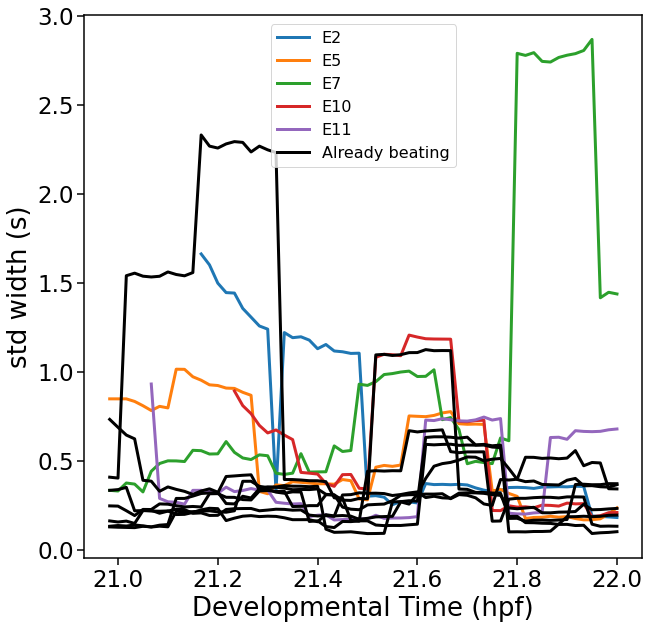

In [204]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["std_width"]/e_data["mean_width"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:     for i in np.arange(0, len(e_data), step=int(window - overlap*window)):
            if len(e_data) - i < window:
                break
            peak_indices = (peaks>=i)*(peaks<(i+window))
            window_peaks = peaks[peak_indices]
            widths = (peak_prominence[peak_indices])
            
            mean_width = np.mean(width_results[0][peak_indices])/fs
            isi = []
            for edge_pair in segment_edges:
                segment_peaks = window_peaks[(window_peaks >= edge_pair[0])*(window_peaks <= edge_pair[1])]
                if len(segment_peaks) > 1:
    #                 hpf = t[i]/3600 + start_hpf
                    isi.extend(list((segment_peaks[1:] - segment_peaks[:-1])/fs))
            mean_isi = np.mean(isi)
            n_intervals = len(isi)
            if n_intervals > 5:
                std_isi = np.std(isi)
                std_width = np.std(width_results[0][peak_indices]/fs)
            else:
                std_isi = np.nan
                std_width = np.nan
            mean_freq = len(window_peaks)/((window - np.sum(missing[i:i+window]))/fs)
            spike_stats_by_roi.append((roi+1, t[i], mean_freq, mean_isi, std_isi, mean_prom, mean_width, std_width, n_intervals))
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["std_width"]/e_data["mean_width"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"std width (s)")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
# ax1.set_ylim(0,3)
lines.append(l)
ax1.legend(handles=lines)

### See if there is correlation between spike width and interspike interval

In [26]:
dobj.peaks_data

,peak_idx,prominence,fwhm,isi,t
roi,,,,,
0,31822,0.139666,1.840318,119.607843,3431.901961
0,33042,0.138837,1.632137,37.254902,3551.509804
0,33422,0.142923,1.693123,48.137255,3588.764706
0,33913,0.144908,1.791467,26.176471,3636.901961
0,34180,0.129825,1.431723,42.450980,3663.078431
...,...,...,...,...,...
10,90163,0.019804,1.090573,9.117647,9151.607843
10,90256,0.023542,1.337983,6.960784,9160.725490
10,90327,0.019766,1.067929,8.529412,9167.686275


In [38]:
def generate_all_peaks_stats(dff, rois, prominence, missing_data=None):
    spikes_by_roi = []
    
    for roi in rois:
        e_data = dff[roi,:]
        peaks, properties = signal.find_peaks(e_data, prominence=prominence, wlen=400)
        peak_prominence = properties["prominences"][e_data[peaks]>0]
        peaks = peaks[e_data[peaks]>0]
        if missing_data is not None:
            peaks = peaks[missing_data[peaks]==False]
            peak_prominence = peak_prominence[missing_data[peaks]==False]
        times = peaks/fs
        width_results = signal.peak_widths(e_data, peaks, rel_height=0.5)[0]/fs
        dat = np.concatenate([np.ones((len(times),1))*(roi+1), times[:,np.newaxis], peak_prominence[:,np.newaxis], width_results[:,np.newaxis]], axis=1)
        dat = pd.DataFrame(dat, columns=["embryo", "offset_s", "prominence", "width"])
        isi = np.array([np.nan] + list(times[1:] - times[:-1]))
        dat["isi"] = isi
        spikes_by_roi.append(dat)
    spikes_by_roi = pd.concat(spikes_by_roi, axis=0)
    spikes_by_roi["hpf"] = spikes_by_roi["offset_s"]/3600 + start_hpf

    return spikes_by_roi

In [39]:
rois = np.arange(dff.shape[0])
spikes_by_roi = generate_all_peaks_stats(dff, rois, 0.02, missing_data=missing)
spikes_by_roi = spikes_by_roi.reset_index().set_index(["embryo"])

(0.0, 3.0)

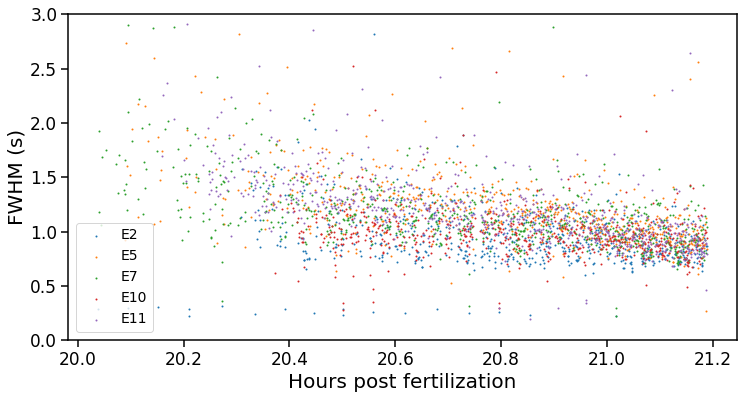

In [42]:
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
fig1, ax1 = plt.subplots(figsize=(12,6))
for e in embryos:
    edata = spikes_by_roi.loc[e]
    
    ax1.scatter(edata["hpf"], edata["width"], s=1, label="E%d" % e)
ax1.set_xlabel("Hours post fertilization")
ax1.set_ylabel("FWHM (s)")
ax1.legend()
ax1.set_ylim((0,3))

Text(0, 0.5, 'ISI(s)')

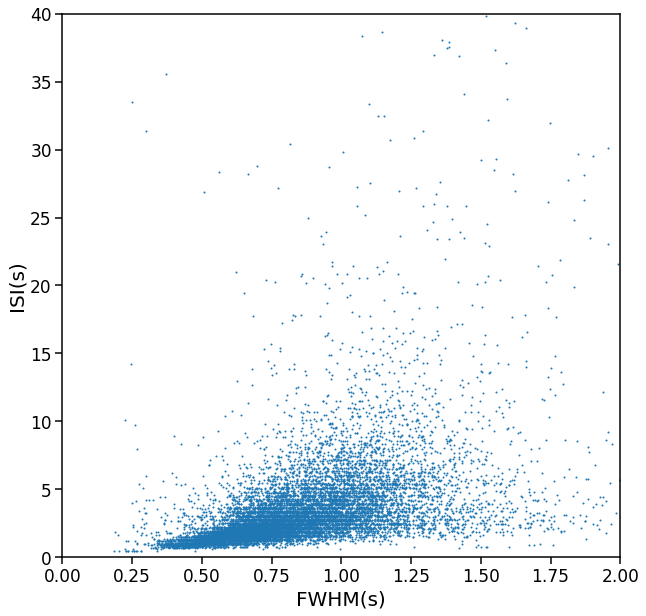

In [47]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(spikes_by_roi["width"], spikes_by_roi["isi"], s=1)
ax1.set_xlim(0,2)
ax1.set_ylim(0,40)
ax1.set_xlabel("FWHM(s)")
ax1.set_ylabel("ISI(s)")

In [25]:
dobj.peaks_data

,peak_idx,prominence,fwhm,isi,t
roi,,,,,
0,31822,0.139666,1.840318,119.607843,3431.901961
0,33042,0.138837,1.632137,37.254902,3551.509804
0,33422,0.142923,1.693123,48.137255,3588.764706
0,33913,0.144908,1.791467,26.176471,3636.901961
0,34180,0.129825,1.431723,42.450980,3663.078431
...,...,...,...,...,...
10,90163,0.019804,1.090573,9.117647,9151.607843
10,90256,0.023542,1.337983,6.960784,9160.725490
10,90327,0.019766,1.067929,8.529412,9167.686275


### Look at peak magnitudes

Can we also look at skew to check whether amplitudes are growing? Maybe this will help estimate a baseline for spike detection as well?

In [34]:
def measure_baseline_noise(dff, rois, window, height, height_percentile=False, overlap=0.5, missing_data=None):
    dispersion = []
    for roi in rois:
        e_data = np.ma.masked_array(dff[roi,:], missing_data)
        for i in np.arange(0, len(e_data), step=int(window - overlap*window)):
            window_data = e_data[i:i+window]
            window_data = window_data[~window_data.mask]
            if height_percentile:
                threshold = np.percentile(window_data, height)
            else:
                threshold = height
            full_std = np.std(window_data)
            threshold_std = np.std(window_data[window_data<threshold])
            full_skew = stats.skew(window_data)
            threshold_skew = stats.skew(window_data[window_data<threshold])
            dispersion.append((roi+1, t[i], full_std, threshold_std, full_skew, threshold_skew))
    dispersion = pd.DataFrame(dispersion, columns=["embryo", "offset", "full_std", "threshold_std", "full_skew", "threshold_skew"])
    dispersion["hpf"] = dispersion["offset"]/3600 + start_hpf
    return dispersion


In [79]:
rois = [1,4,6,9,10]
window = 6120
overlap = 0.9
dispersion_df = measure_baseline_noise(dff, rois, window, height = 0.015, overlap=overlap, missing_data=missing)

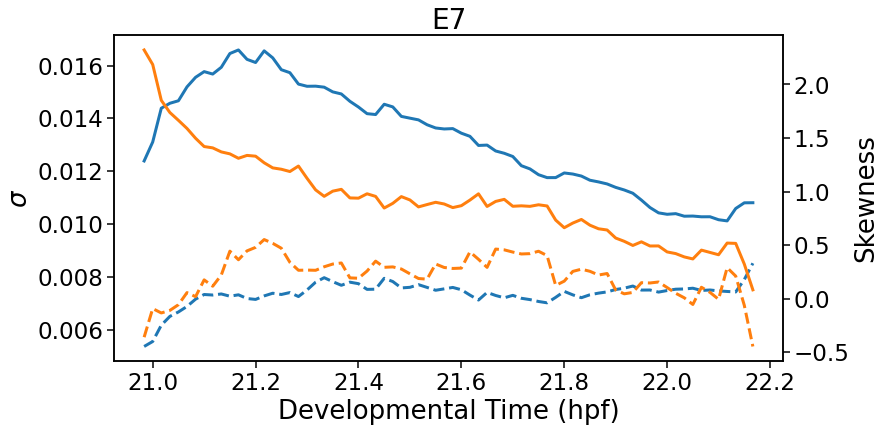

In [80]:
dispersion_df = dispersion_df.reset_index().set_index(["embryo"])
fig1, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
embryos = [r+1 for r in rois]
idx = 2
embryo_data = dispersion_df.loc[embryos[idx]]
ax1.set_title("E%d" % embryos[idx])
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"$\sigma$")
ax2.set_ylabel("Skewness")
ax1.plot(embryo_data["hpf"], embryo_data["full_std"])
ax1.plot(embryo_data["hpf"], embryo_data["threshold_std"], "--",color="C0")
ax2.plot(embryo_data["hpf"], embryo_data["full_skew"], color="C1")
ax2.plot(embryo_data["hpf"], embryo_data["threshold_skew"], "--",color="C1")

This will tell us whether there are small peaks on top of large calcium elevations.

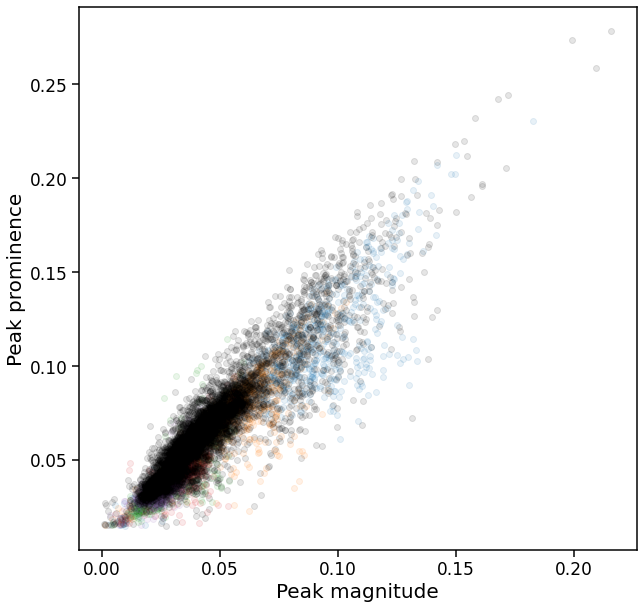

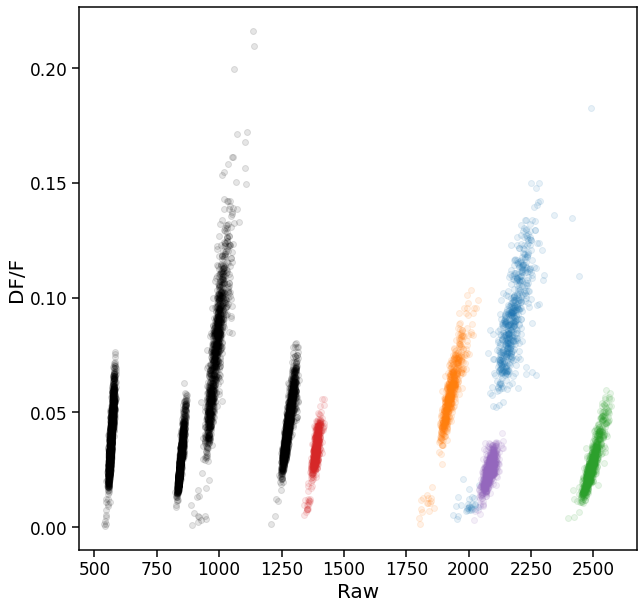

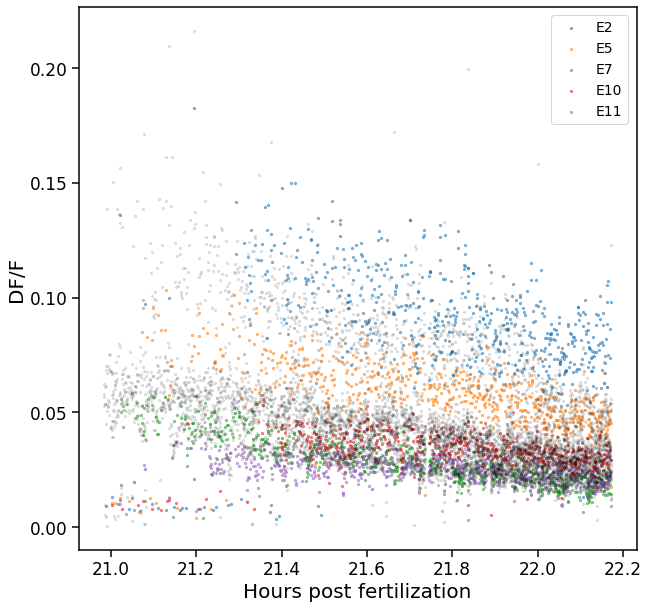

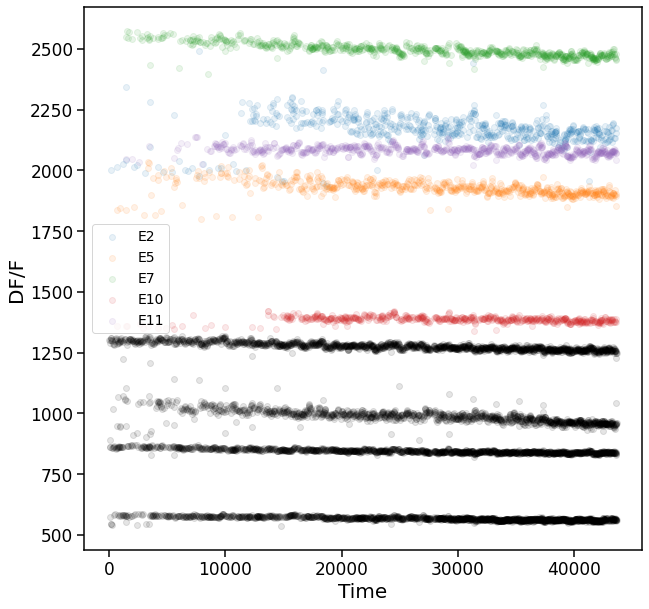

In [37]:
rois = [1,4,6,9,10]
window = 6120
overlap = 0.9
prominence = 0.015
segment_edges = find_segment_edges(missing)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel("Peak magnitude")
ax1.set_ylabel("Peak prominence")

fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.set_xlabel("Raw")
ax2.set_ylabel("DF/F")

fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_xlabel("Hours post fertilization")
ax3.set_ylabel("DF/F")

fig4, ax4 = plt.subplots(figsize=(10,10))
ax4.set_xlabel("Time")
ax4.set_ylabel("DF/F")
# ax2.set_ylim((0,0.4))

# rois = np.arange(dff.shape[0])

for roi in rois:
    e_data = dff[roi,:]
    peaks, properties = signal.find_peaks(e_data, prominence=prominence)
    peak_prominence = properties["prominences"][e_data[peaks]>0]
    peaks = peaks[e_data[peaks]>0]
    ax1.scatter(e_data[peaks], peak_prominence, alpha = 0.1, label="E%d" % (roi+1))
    ax2.scatter(raw[roi,peaks], e_data[peaks], alpha=0.1, label="E%d" % (roi+1))
    ax3.scatter(hours[peaks], e_data[peaks], alpha=0.5, label="E%d" % (roi+1), s=5)
    ax4.scatter(peaks, raw[roi,peaks], alpha=0.1, label="E%d" % (roi+1))

ax3.legend()
ax4.legend()
    
beating_embryos = [4,6,12,13]
for embryo in beating_embryos:
    e_data = dff[embryo-1,:]
    peaks, properties = signal.find_peaks(e_data, prominence=prominence)
    peak_prominence = properties["prominences"][e_data[peaks]>0]
    peaks = peaks[e_data[peaks]>0]
    ax1.scatter(e_data[peaks], peak_prominence, alpha = 0.1, color="black")
    ax2.scatter(raw[embryo-1,peaks], e_data[peaks], alpha=0.1, color="black")
    ax3.scatter(hours[peaks], e_data[peaks], alpha=0.1, color="black",s=5)
    ax4.scatter(peaks, raw[embryo-1,peaks], alpha=0.1, color="black")

No, seems mostly 1 to 1. Also DF/F and raw fluorescence 

### Autocovariance heatmap

In [407]:
roi = 6
max_idx = 474
start_time = 12
end_time=36
timepoints = np.arange(start_time, end_time)
z_img = np.zeros((len(timepoints), max_idx))
pxx_img = np.zeros((len(timepoints), max_idx))
hours = []
lag = np.arange(max_idx)/fs
for idx in timepoints:
    exptname = expt_info["file_name"].loc[idx]
    hour = expt_info["hpf"].loc[idx]
    hours.append(hour)
    data = pd.read_csv("%s_traces.csv" % exptname).set_index("z").loc[0].set_index("region")
    
    dFF_mean, dFFs = get_mean_signal_pd(data, np.unique(data.index), interval=(start,0), window=window)

    dFF = dFFs[roi]
    dFF = (dFF - np.mean(dFF))
    z = signal.correlate(dFF, dFF, mode='same')
    f, pxx = signal.periodogram(dFF, fs=fs)
    z_img[idx-timepoints[0],:] = z[z.shape[0]//2:z.shape[0]//2+max_idx]
    pxx_img[idx-timepoints[0],:] = pxx[:max_idx]
    

In [408]:
e_data = spike_stats_by_roi.loc[roi+1].iloc[start_time:end_time]

In [ ]:
hours = np.array(hours)
fig1, ax1 = plt.subplots(figsize=(10,10))
width = z_img.shape[1]
lag_offset = 12
print(width)
im = ax1.imshow(z_img[:,lag_offset:], extent=(0, width-lag_offset, width, 0), vmax=np.max(z_img[:,lag_offset:].ravel()), vmin=-np.max(z_img[:,lag_offset:].ravel()))
cbar = ax1.figure.colorbar(im, aspect=20, shrink=0.7, label=r"$K_{xx}(\tau)$")
yticklabels = list(hours[np.linspace(0, len(timepoints), num=5, dtype=int, endpoint=False)])
yticklabels = ["%.1f" % t for t in yticklabels]
xticklabels = list(lag[np.linspace(lag_offset, len(lag), num=5, dtype=int, endpoint=False)])
xticklabels = ["%.2f" % t for t in xticklabels]
ax1.set_yticklabels(yticklabels)
ax1.set_xticklabels(xticklabels)
ax1.set_ylabel("Developmental Time (hpf)")
ax1.set_xlabel("Lag (s)")

ax1.set_xlim(0, width-lag_offset)
ax1.set_ylim(0,width)
ax1.invert_yaxis()
ax1.plot((1/e_data["mean_freq"] - lag[lag_offset])*(width-lag_offset)/(lag[-1]-lag[lag_offset]),(e_data["hpf"]-hours[0])*width/(hours[-1]-hours[0]), label= "Mean ISI(s)", color="black")
ax1.legend()
ax1.set_title("E%d" % (roi+1))
plt.tight_layout()

### Spectrogram

In [151]:
np.where(expt_info["hpf"] >21.3)

(array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131]),)

In [15]:
roi = nice_embryos[-2]-1
f, t_s, Sxx = signal.spectrogram(dff[roi,:]-np.mean(dff[roi,:]), fs=fs, nperseg=1200, noverlap=600)

/home/billjia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 1.0, 'E9')

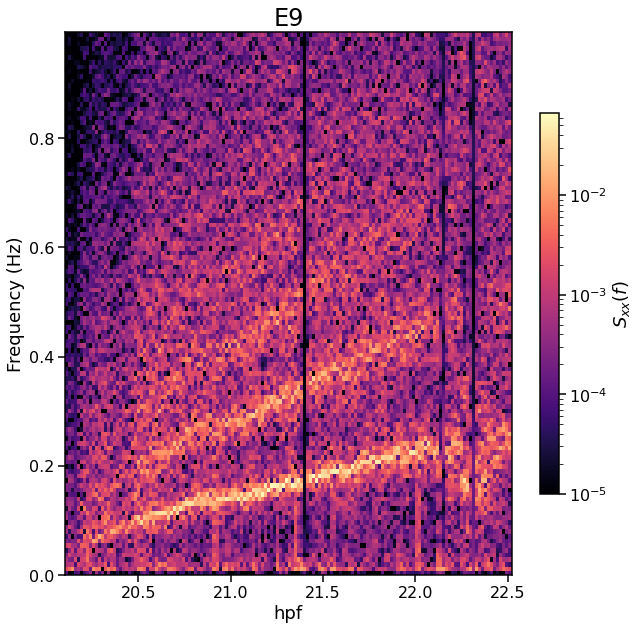

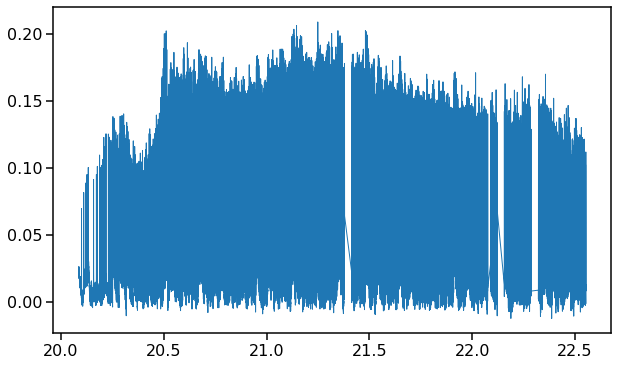

In [23]:
fig1, ax1 = plt.subplots(figsize=(10,10))
img = ax1.pcolormesh((t_s+np.min(t))/3600 + start_hpf, f[f<1], Sxx[f<1,:], cmap="magma", norm=colors.LogNorm(vmin=1e-5))
cbar = ax1.figure.colorbar(img, aspect=20, shrink=0.7, label=r"$S_{xx}(f)$")
fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(t/3600 + start_hpf, dff[roi,:])
ax1.set_xlabel("hpf")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("E%d" %(roi+1))
# ax1.axvline(21.3)

(21.018, 21.048)

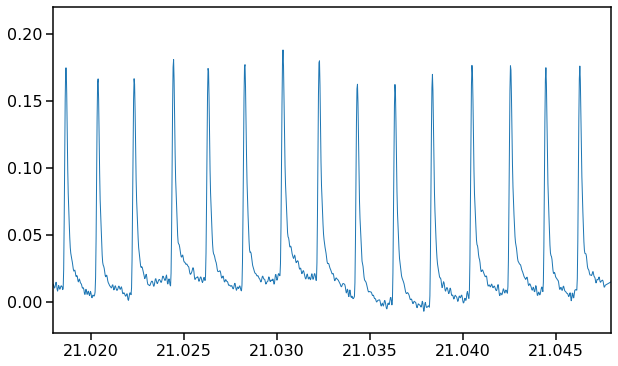

In [24]:
fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(t/3600 + start_hpf, dff[roi,:])
ax2.set_xlim(21.018, 21.048)

In [39]:
x

array([0.00000e+00, 1.00001e-02, 2.00002e-02, ..., 9.99980e+02,
       9.99990e+02, 1.00000e+03])

In [ ]:
x0 = np.linspace(0, 100, 100)

In [53]:
y = np.arange(len(x))%100 == 0

In [71]:
kern = np.exp(-np.arange(1000)/10)

In [72]:
y1 = signal.convolve(y, kern, mode="same")

(0.0, 10.0)

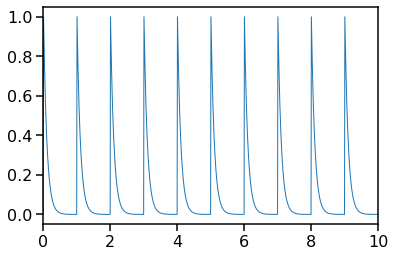

In [73]:
plt.plot(x,y1)
plt.xlim(0,10)

In [78]:
f, pxx = signal.periodogram(kern)

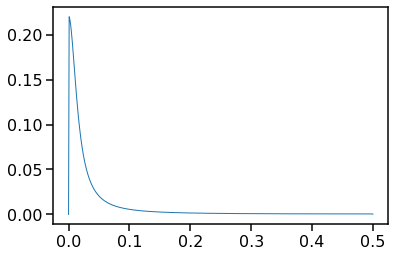

In [79]:
plt.plot(f, pxx)

In [76]:
f, t_s, Sxx = signal.spectrogram(y1, nperseg=1200, noverlap=600)

/home/billjia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


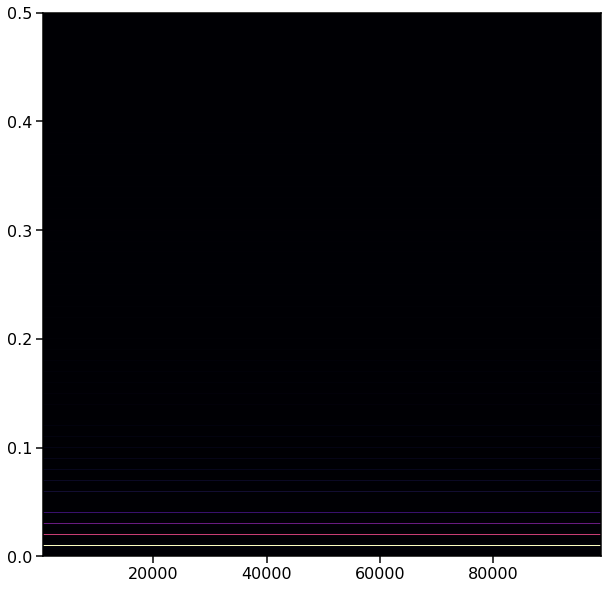

In [77]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pcolormesh(t_s,f, Sxx, cmap="magma")